In [5]:
import pandas as pd
import numpy as np
import os
from scipy import stats
from tqdm import tqdm
import pylab as pl
import datetime

### 1. Import data from May 2016

In [6]:
data=pd.read_csv('c:\Users\AK\Documents\GitHub\NYTaxi/yellow_tripdata_2016-05.csv')

In [7]:
data.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76
5,2,2016-05-01 00:00:00,2016-05-01 00:05:19,2,0.63,-73.979294,40.755764,1,N,-73.988014,40.758469,1,5.0,0.5,0.5,0.00,0.0,0.3,6.30
6,2,2016-05-01 00:00:00,2016-05-01 00:15:43,1,6.68,-73.981544,40.780739,1,N,-73.937805,40.855343,1,20.5,0.5,0.5,2.00,0.0,0.3,23.80
7,2,2016-05-01 00:00:00,2016-05-01 00:06:31,1,1.48,-73.987198,40.750507,1,N,-73.980797,40.767826,1,7.0,0.5,0.5,1.66,0.0,0.3,9.96
8,2,2016-05-01 00:00:00,2016-05-01 00:00:00,4,1.59,-74.001610,40.740990,1,N,-73.981079,40.730675,1,8.0,0.5,0.5,0.00,0.0,0.3,9.30
9,2,2016-05-01 00:00:00,2016-05-01 00:00:00,3,3.52,-74.013855,40.714119,1,N,-73.994049,40.761452,2,13.0,0.5,0.5,0.00,0.0,0.3,14.30


In [8]:
data.shape

(11836853, 19)

### 2. Filter the data to remove rides with: 
- zero duration
- zero number of passengers
- zero distance according to the meter
- starting coords outside of NY

In [9]:
data=data[(pd.to_datetime(data.tpep_dropoff_datetime)-pd.to_datetime(data.tpep_pickup_datetime) ).astype('timedelta64[s]')>0]
data.shape

(11824526, 19)

In [10]:
data = data[data.passenger_count != 0]
data.shape

(11824004, 19)

In [11]:
data=data[data.trip_distance>0]
data.shape

(11763366, 19)

In [12]:
data=data[(data.pickup_longitude>=-74.25559) & (data.pickup_longitude<=-73.70001) & (data.pickup_latitude>=40.49612) & (data.pickup_latitude<=40.91553)]
data.shape

(11626521, 19)

### 2a. Remove minutes and seconds from pickup time

In [13]:
data.tpep_pickup_datetime=pd.to_datetime(data.tpep_pickup_datetime).map(lambda t: t.strftime('%Y-%m-%d %H'))

In [14]:
data.reset_index(drop=True,inplace=True)

In [15]:
data.tail(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
11626511,1,2016-05-31 23,2016-06-01 00:10:18,1,2.30,-73.975784,40.789474,1,N,-73.994179,40.764069,1,10.0,0.5,0.5,2.26,0.0,0.3,13.56
11626512,1,2016-05-31 23,2016-06-01 00:07:37,2,1.50,-73.972435,40.754684,1,N,-73.985435,40.738312,1,7.5,0.5,0.5,1.75,0.0,0.3,10.55
11626513,1,2016-05-31 23,2016-06-01 00:22:49,1,16.20,-73.992004,40.714870,1,N,-73.735626,40.761299,1,45.0,0.5,0.5,9.25,0.0,0.3,55.55
11626514,2,2016-05-31 23,2016-05-31 23:58:04,1,1.05,-73.978851,40.787628,1,N,-73.988693,40.775139,1,6.0,0.5,0.5,2.19,0.0,0.3,9.49
11626515,2,2016-05-31 23,2016-06-01 00:05:46,1,2.91,-73.981491,40.728870,1,N,-73.997620,40.755169,2,11.5,0.5,0.5,0.00,0.0,0.3,12.80
11626516,2,2016-05-31 23,2016-06-01 00:00:24,2,1.89,-73.947876,40.774818,1,N,-73.974274,40.779797,1,8.0,0.5,0.5,1.86,0.0,0.3,11.16
11626517,2,2016-05-31 23,2016-06-01 00:19:36,1,15.21,-73.789467,40.646942,1,N,-73.893929,40.731426,1,42.0,0.5,0.5,8.66,0.0,0.3,51.96
11626518,2,2016-05-31 23,2016-05-31 23:59:07,1,1.80,-74.008659,40.719723,1,N,-73.999580,40.743649,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56
11626519,2,2016-05-31 23,2016-06-01 00:05:47,1,2.28,-73.981644,40.758862,1,N,-73.952637,40.766491,1,11.0,0.5,0.5,2.46,0.0,0.3,14.76
11626520,1,2016-05-19 03,2016-05-19 03:31:24,1,0.60,-73.948959,40.586658,1,Y,-73.948570,40.594837,2,4.0,0.5,0.5,0.00,0.0,0.3,5.30


### 2b. Read in coordinates of different regions in New York

In [17]:
coords=pd.read_csv(os.path.join('c:\Users\AK\Documents\GitHub\NYTaxi','regions.csv'),sep=';')
coords.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


In [18]:
coords.shape

(2500, 5)

### 2c. Add 2 columns to the data to describe: 
- pickup time in hours from the beginning of the month
- region number according to the reference file

In [19]:
t0=datetime.datetime(2016, 5, 1, 0)
t0=t0.strftime('%Y-%m-%d %H')
data['tpep_pickup_hrs']=(pd.to_datetime(data.tpep_pickup_datetime)-pd.to_datetime(t0)).astype('timedelta64[h]')

In [20]:
pd.to_datetime(t0)

Timestamp('2016-05-01 00:00:00')

In [21]:
data["region"] = np.nan

In [22]:
%%time
for j in range(len(coords)):
    if j%500==0: 
        print j
    data.region[(data.pickup_longitude>coords.west[j]) & (data.pickup_longitude<coords.east[j]) & (data.pickup_latitude>coords.south[j]) & (data.pickup_latitude<coords.north[j])]=coords.region[j]

0


C:\Users\AK\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


500
1000
1500
2000
Wall time: 29min


In [23]:
data.tail(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,tpep_pickup_hrs,region
11626511,1,2016-05-31 23,2016-06-01 00:10:18,1,2.30,-73.975784,40.789474,1,N,-73.994179,...,1,10.0,0.5,0.5,2.26,0.0,0.3,13.56,743.0,1285.0
11626512,1,2016-05-31 23,2016-06-01 00:07:37,2,1.50,-73.972435,40.754684,1,N,-73.985435,...,1,7.5,0.5,0.5,1.75,0.0,0.3,10.55,743.0,1281.0
11626513,1,2016-05-31 23,2016-06-01 00:22:49,1,16.20,-73.992004,40.714870,1,N,-73.735626,...,1,45.0,0.5,0.5,9.25,0.0,0.3,55.55,743.0,1177.0
11626514,2,2016-05-31 23,2016-05-31 23:58:04,1,1.05,-73.978851,40.787628,1,N,-73.988693,...,1,6.0,0.5,0.5,2.19,0.0,0.3,9.49,743.0,1235.0
11626515,2,2016-05-31 23,2016-06-01 00:05:46,1,2.91,-73.981491,40.728870,1,N,-73.997620,...,2,11.5,0.5,0.5,0.00,0.0,0.3,12.80,743.0,1228.0
11626516,2,2016-05-31 23,2016-06-01 00:00:24,2,1.89,-73.947876,40.774818,1,N,-73.974274,...,1,8.0,0.5,0.5,1.86,0.0,0.3,11.16,743.0,1384.0
11626517,2,2016-05-31 23,2016-06-01 00:19:36,1,15.21,-73.789467,40.646942,1,N,-73.893929,...,1,42.0,0.5,0.5,8.66,0.0,0.3,51.96,743.0,2068.0
11626518,2,2016-05-31 23,2016-05-31 23:59:07,1,1.80,-74.008659,40.719723,1,N,-73.999580,...,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,743.0,1127.0
11626519,2,2016-05-31 23,2016-06-01 00:05:47,1,2.28,-73.981644,40.758862,1,N,-73.952637,...,1,11.0,0.5,0.5,2.46,0.0,0.3,14.76,743.0,1232.0
11626520,1,2016-05-19 03,2016-05-19 03:31:24,1,0.60,-73.948959,40.586658,1,Y,-73.948570,...,2,4.0,0.5,0.5,0.00,0.0,0.3,5.30,435.0,1361.0


In [24]:
data.to_pickle('yellow_tripdata_2016-05_cleaned.pkl')

### 3. Aggregate data based on hours and New York regions

In [25]:
print min(data.tpep_pickup_hrs), max(data.tpep_pickup_hrs)

0.0 743.0


In [26]:
binx=np.linspace(min(data.tpep_pickup_hrs),max(data.tpep_pickup_hrs)+1,max(data.tpep_pickup_hrs)+2)
#binx=np.linspace(0,744,745)
biny=np.linspace(1,len(coords)+1,len(coords)+1)

ret = stats.binned_statistic_2d(data.tpep_pickup_hrs, data.region, None, statistic='count', bins=[binx,biny])

In [27]:
stat_shape=ret.statistic.shape
print stat_shape

(744L, 2500L)


In [28]:
print len(binx[:744])

744


In [29]:
data_aggregate = pd.DataFrame({'Time':np.repeat( binx[:stat_shape[0]],stat_shape[1] ), 'Region':np.tile( biny[:stat_shape[1]],stat_shape[0]), 'Count':ret.statistic.flatten()})

In [30]:
data_aggregate.shape

(1860000, 3)

In [31]:
744*2500

1860000

### 4. Display first few lines of the aggregate table

In [32]:
data_aggregate.head(20)

,Count,Region,Time
0,0.0,1.0,0.0
1,0.0,2.0,0.0
2,0.0,3.0,0.0
3,0.0,4.0,0.0
4,0.0,5.0,0.0
5,0.0,6.0,0.0
6,0.0,7.0,0.0
7,0.0,8.0,0.0
8,0.0,9.0,0.0
9,0.0,10.0,0.0


### 5. Plot number of yellow cab rides for region containing the Empire State Building.

In [33]:
#Empire State Building coordinates: 40.74853° N, -73.98603° W
ESB_N=40.74853 
ESB_W=-73.98603 

print 'Region #',coords[(coords.west<ESB_W) & (coords.east>ESB_W) & (coords.south<ESB_N) & (coords.north>ESB_N)]['region']

Region # 1230    1231
Name: region, dtype: int64


In [34]:
coords.iloc[1230]

region    1231.000000
west       -73.988912
east       -73.977800
south       40.747766
north       40.756154
Name: 1230, dtype: float64

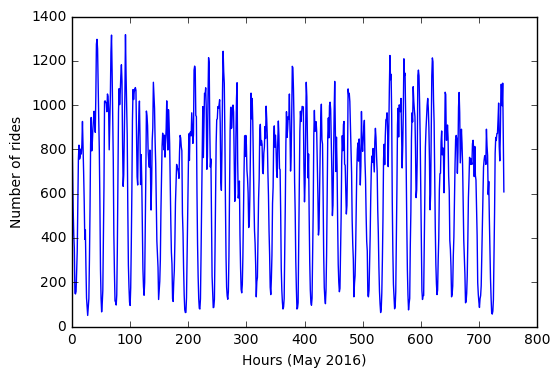

In [35]:
pl.plot(data_aggregate.Time[data_aggregate.Region==1231], data_aggregate.Count[data_aggregate.Region==1231])
pl.xlabel("Hours (May 2016)")
pl.ylabel("Number of rides")
pl.show()

### Downward spikes (31 total) clearly correspond to drop in taxi rides during night time

## 6. Calculate number of pairs hour*region in May 2016, where there were zero rides

In [36]:
print 'Number of zero ride pairs: ',data_aggregate.Count[data_aggregate.Count==0].shape[0]
#np.sum(ret.statistic==0)

Number of zero ride pairs:  1718238


In [37]:
data_aggregate.to_pickle('yellow_tripdata_2016-05.pkl')